## PART C: Modeling

In [1]:
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from sklearn.metrics import classification_report

## Setting Seed for Reproducibility
This function set_seeds is used to ensure that all random operations can be replicated identically by fixing the seed for randomness. This is essential for experiments where reproducibility is crucial. The function sets seeds for different libraries (Python's random, NumPy, and PyTorch) and makes sure that CUDA operations are deterministic if CUDA is available.

In [2]:
### Setting Seed for Reproducibility
def set_seeds(seed):
    random.seed(seed) # Seed the random number generator for Python's random module
    np.random.seed(seed)  # Seed the random number generator for NumPy
    torch.manual_seed(seed) # Seed the random number generator for PyTorch
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
set_seeds(0) # Initialize seeds

## Create Dataset
This section loads and processes the dataset. It reads data from a CSV file and augments it with data from a financial phrasebank dataset. Data is split into training and validation sets, and combined with additional data (new_x and new_y).

In [3]:
new_df = pd.read_csv('final-data-updated.csv', encoding='utf-8-sig') # Read data from a CSV file
new_df = new_df.dropna(subset=['Sentiment'])
new_x = new_df['Summary'].tolist() # Convert the 'Summary' column into a list
new_y = new_df['Sentiment'].tolist() # Convert the 'Sentiment' column into a list

dataset = load_dataset('financial_phrasebank', 'sentences_50agree') # Load a dataset from the HuggingFace datasets library
train_dataset = dataset['train'] # Access the training portion of the dataset

# Split the dataset into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(train_dataset['sentence'], train_dataset['label'], test_size=0.2, random_state=42)
x_train += new_x # Extend the training data with additional summaries
y_train += new_y # Extend the training labels with additional sentiments

print("Trainset:", len(x_train))
print("Validset:", len(x_valid))

Trainset: 6152
Validset: 970


## Dataset Class Definition
This class News is a custom dataset class inheriting from PyTorch's Dataset. It is designed to handle pairs of data (x, y) where x is input data and y is labels. The methods __getitem__ and __len__ are overridden to provide mechanisms for indexing the dataset and getting its length, respectively.

In [4]:
### Dataset Class Definition
class News(Dataset):
    def __init__(self, x, y):
        self.x = x # Store the input data
        self.y = y # Store the labels

          
    def __getitem__(self, index):
        return self.x[index], self.y[index] # Return a tuple of (input, label) at the specified index
       
    def __len__(self):
        return len(self.x) # Return the total number of items in the dataset
    
trainset = News(x_train, y_train) # Create an instance of the dataset class for training data
validset = News(x_valid, y_valid) # Create an instance of the dataset class for validation data

## Data Loading and Tokenization
This snippet sets up data loaders with a custom collate_fn that processes batches of text data by tokenizing them using a pre-trained BERT tokenizer (ProsusAI/finbert). The tokenizer converts text into a format suitable for BERT model input, including padding to a maximum length.

In [5]:
### Data Loading and Tokenization
def collate_fn(batch):    
    (x, y) = zip(*batch) # Unzip the batch into separate lists of inputs and labels
    # Tokenize the text and convert into tensors suitable for model input
    x = tokenizer(x, max_length=512, truncation=True, padding="longest", return_tensors='pt')
    y = {'labels': torch.LongTensor(y)} # Convert labels into a tensor
    return {**x, **y}
# Create DataLoader instances for training and validation datasets    
tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert") # Load a pre-trained tokenizer
train_loader = DataLoader(trainset, batch_size = 16, shuffle = True, num_workers = 0, pin_memory = True, collate_fn=collate_fn)
valid_loader = DataLoader(validset, batch_size = 16, shuffle = True, num_workers = 0, pin_memory = True, collate_fn=collate_fn)

## Model Setup and Training Functions
In this section, the model and its environment are set up. A BERT model for sequence classification is loaded with specific configurations and moved to a GPU if available. The training and validation functions are defined here, including mechanisms for optimizing the model, computing loss, and updating model parameters. The training process includes feedback on progress and accuracy, and incorporates early stopping for efficient training.

In [6]:
### Model Setup and Training Functions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Setup device for model
# Load a pre-trained BERT model (Finbert) for sequence classification with three output labels
model = BertForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels = 3, ignore_mismatched_sizes=True)
model.to(device) # Move the model to the specified device
optimizer = optim.AdamW(model.parameters(), lr=5e-5) # Initialize an optimizer for the model parameters

#### Train
This code snippet performs the fine-tuning of a model using a training loop. The fine-tuning process involves training a pre-trained model on a specific dataset provided by train_loader. The model processes input data from the iterator through forward propagation to compute outputs, including loss and predictions. Backpropagation is then performed, and model weights are updated accordingly. This process is repeated for each epoch over the entire dataset. Fine-tuning aims to adapt the model more closely to the specific characteristics of the dataset or application scenario.

#### Valid
This code snippet is designed to evaluate the performance of a model. During validation, the model is set to evaluation mode (model.eval()), which disables mechanisms like Dropout that are specific to the training phase. The use of torch.no_grad() ensures that no gradients are calculated, saving computational resources. The code iterates through the validation dataset provided by valid_loader, processing each batch of data and calculating loss and accuracy. It then returns the average loss and accuracy across the entire validation set. This process is used to assess the model's generalization ability on new data without making any updates to the model parameters.

In [7]:
### Training Function
def train(epoch):
    train_loss, train_acc = 0, 0 # Initialize loss and accuracy trackers for the epoch
    train_pbar = tqdm(train_loader, position=0, leave=True) # Setup a progress bar for the training loop
    
    model.train() # Set the model to training mode 
    for input_datas in train_pbar: # Loop over batches of data in the training loader
        for key in input_datas.keys():
            input_datas[key] = input_datas[key].to(device)
        optimizer.zero_grad()  # Reset the gradients of the model parameters to zero
        outputs = model(**input_datas) # Pass the batch through the model (forward pass)
        
        logits = outputs.logits # The output values before activation function
        loss = outputs.loss # Calculate the loss for the batch

        loss.backward() # Perform backpropagation to calculate gradients
        optimizer.step() # Update the model's parameters based on gradients
        
        train_pbar.set_description(f'Train Epoch {epoch}')  # Update the progress bar with epoch number
        train_pbar.set_postfix({'loss':f'{loss:.3f}'}) # Update the progress bar with the current loss
        
        pred = torch.argmax(logits, dim = 1) # Get the predicted classes from logits
        train_acc += sum(pred == input_datas['labels']) # Calculate accuracy for the batch
        train_loss += loss.item()  # Sum up the loss of the batch
    return train_loss/len(train_loader), train_acc/len(trainset) # Return average loss and accuracy for the epoch

### Validation Function (almost same as Training)
def valid(epoch):
    valid_loss, valid_acc = 0, 0
    valid_pbar = tqdm(valid_loader, position=0, leave=True)
    y_preds, y_trues = [], []
    model.eval()
    with torch.no_grad(): 
        for input_datas in valid_pbar:
            for key in input_datas.keys():
                input_datas[key] = input_datas[key].to(device)
            
            outputs = model(**input_datas)
            logits = outputs.logits
            loss = outputs.loss
            
            valid_pbar.set_description(f'Valid Epoch {epoch}')
            valid_pbar.set_postfix({'loss':f'{loss:.3f}'})

            pred = torch.argmax(logits, dim = 1)
            valid_acc += sum(pred == input_datas['labels'])
            valid_loss += loss.item()

            y_trues.extend(input_datas['labels'].cpu())
            y_preds.extend(pred.cpu())

    print(classification_report(y_trues, y_preds))

    return valid_loss/len(valid_loader), valid_acc/len(validset) # Return average loss and accuracy for the epoch

### Function to Plot Training and Validation Loss        
def show_training_loss(loss_record):
    train_loss, valid_loss = [i for i in loss_record.values()] # Extract training and validation losses
    
    plt.plot(train_loss)
    plt.plot(valid_loss)
    plt.title('Result')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

This code segment performs training and validation of a model, incorporating an early stopping mechanism to prevent overfitting. During each epoch, it executes training (train(epoch)) and validation (valid(epoch)) processes, and logs the resulting losses and accuracies. If the validation accuracy for a given epoch exceeds the best accuracy recorded in previous epochs, the model updates its best accuracy and saves its parameters to a designated path. If there is no improvement for a consecutive number of epochs, determined by the early_stopping variable, the early stopping mechanism is triggered to prematurely end the training. Finally, if loss display is enabled (show_loss), it visualizes the loss records from the training process.

  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_4700\2777210971.py:6: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)} # Convert labels into a tensor
Valid Epoch 0: 100%|██████████| 61/61 [00:01<00:00, 42.35it/s, loss=0.240]


              precision    recall  f1-score   support

           0       0.78      0.88      0.83       110
           1       0.85      0.93      0.89       571
           2       0.89      0.67      0.76       289

    accuracy                           0.85       970
   macro avg       0.84      0.83      0.83       970
weighted avg       0.85      0.85      0.84       970

Saving Model With Acc 0.84845
Train Loss: 0.55718 Train Acc: 0.77487| Valid Loss: 0.34710 Valid Acc: 0.84845| Best Acc: 0.84845



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_4700\2777210971.py:6: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)} # Convert labels into a tensor
Valid Epoch 1: 100%|██████████| 61/61 [00:01<00:00, 43.40it/s, loss=0.275]


              precision    recall  f1-score   support

           0       0.81      0.90      0.85       110
           1       0.90      0.91      0.90       571
           2       0.84      0.80      0.82       289

    accuracy                           0.87       970
   macro avg       0.85      0.87      0.86       970
weighted avg       0.87      0.87      0.87       970

Saving Model With Acc 0.87320
Train Loss: 0.26328 Train Acc: 0.89987| Valid Loss: 0.36816 Valid Acc: 0.87320| Best Acc: 0.87320



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_4700\2777210971.py:6: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)} # Convert labels into a tensor
Valid Epoch 2: 100%|██████████| 61/61 [00:01<00:00, 42.80it/s, loss=0.198]


              precision    recall  f1-score   support

           0       0.81      0.86      0.83       110
           1       0.89      0.89      0.89       571
           2       0.82      0.79      0.81       289

    accuracy                           0.86       970
   macro avg       0.84      0.85      0.84       970
weighted avg       0.86      0.86      0.86       970

Train Loss: 0.14152 Train Acc: 0.95172| Valid Loss: 0.43429 Valid Acc: 0.86082| Best Acc: 0.87320



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_4700\2777210971.py:6: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)} # Convert labels into a tensor
Valid Epoch 3: 100%|██████████| 61/61 [00:01<00:00, 42.60it/s, loss=0.351]


              precision    recall  f1-score   support

           0       0.87      0.78      0.82       110
           1       0.84      0.95      0.89       571
           2       0.89      0.69      0.78       289

    accuracy                           0.85       970
   macro avg       0.87      0.81      0.83       970
weighted avg       0.86      0.85      0.85       970

Train Loss: 0.09270 Train Acc: 0.96765| Valid Loss: 0.47043 Valid Acc: 0.85361| Best Acc: 0.87320



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_4700\2777210971.py:6: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)} # Convert labels into a tensor
Valid Epoch 4: 100%|██████████| 61/61 [00:01<00:00, 42.34it/s, loss=0.130]


              precision    recall  f1-score   support

           0       0.90      0.75      0.82       110
           1       0.89      0.89      0.89       571
           2       0.78      0.83      0.80       289

    accuracy                           0.85       970
   macro avg       0.86      0.82      0.84       970
weighted avg       0.86      0.85      0.85       970

Train Loss: 0.06541 Train Acc: 0.97919| Valid Loss: 0.59757 Valid Acc: 0.85464| Best Acc: 0.87320



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_4700\2777210971.py:6: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)} # Convert labels into a tensor
Valid Epoch 5: 100%|██████████| 61/61 [00:01<00:00, 43.00it/s, loss=0.929]


              precision    recall  f1-score   support

           0       0.87      0.72      0.79       110
           1       0.83      0.96      0.89       571
           2       0.89      0.66      0.76       289

    accuracy                           0.84       970
   macro avg       0.86      0.78      0.81       970
weighted avg       0.85      0.84      0.84       970

------------------------------------
|Model can't improve, stop training|
------------------------------------


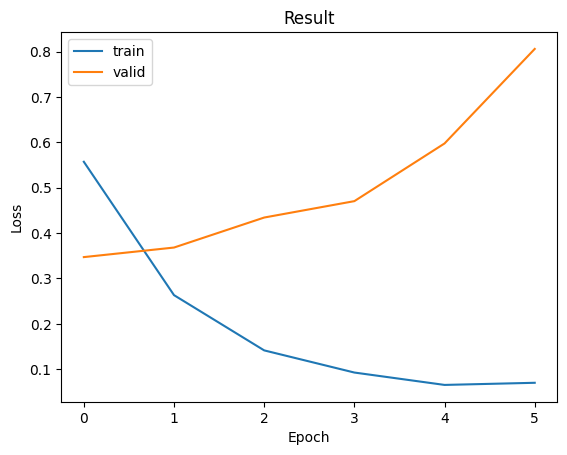

In [8]:
### Main Training Loop
epochs = 10  # Total number of epochs to train                            
early_stopping = 4  # Number of epochs to stop training if no improvement                      
stop_cnt = 0  # Counter for early stopping                        
model_path = 'model.ckpt'  # Path to save the best model               
show_loss = True  # Flag to show loss after training                       
best_acc = 0  # Tracker for the best accuracy                            
loss_record = {'train':[], 'valid':[]}   # Record of training and validation loss

for epoch in range(epochs):   # Loop over each epoch
    train_loss, train_acc = train(epoch) # Train the model for one epoch
    valid_loss, valid_acc = valid(epoch) # Validate the model for one epoch
    
    loss_record['train'].append(train_loss) # Record training loss
    loss_record['valid'].append(valid_loss) # Record validation loss
    
    # Check for best model
    if valid_acc > best_acc:
        best_acc = valid_acc # Update the best accuracy
        torch.save(model.state_dict(), model_path) # Save the model
        print(f'Saving Model With Acc {best_acc:.5f}')
        stop_cnt = 0 # Reset the early stopping counter
    else:
        stop_cnt+=1 # Increment the early stopping counter
    
    # Early stopping
    if stop_cnt == early_stopping:
        output = "Model can't improve, stop training"
        print('-' * (len(output)+2))
        print(f'|{output}|')
        print('-' * (len(output)+2))
        break

    # Print training and validation statistics
    print(f'Train Loss: {train_loss:.5f} Train Acc: {train_acc:.5f}', end='| ')
    print(f'Valid Loss: {valid_loss:.5f} Valid Acc: {valid_acc:.5f}', end='| ')
    print(f'Best Acc: {best_acc:.5f}', end='\n\n')

if show_loss:
    show_training_loss(loss_record) # Show loss plot if flag is true

The FinBERT model training output indicates a high training accuracy of 97.9% with a low training loss, while the validation accuracy peaks at 87.32%. However, the validation loss trends higher after the first epoch, suggesting overfitting. The model demonstrates strong performance in classifying one of the classes with a recall of 96%, yet this class also exhibits a relatively high false positive rate. An early stopping mechanism has terminated further training to prevent overfitting. The imbalanced class distribution might be affecting the model's performance and should be considered in future improvements